In [108]:
import pandas as pd
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from hazm import Normalizer as hazm_normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
from sklearn.preprocessing import Normalizer as vec_normalizer
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MiniBatchKMeans
import string


In [109]:
df = pd.read_csv("./golestan.csv")

print(df.shape)
print(df.columns)


(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [110]:
df.head()


,hekayt,bab
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,1
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,1
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,1
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,1
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,1


In [111]:
df = df.dropna(subset=["hekayt"])
df = df.dropna(subset=["bab"])

print(df.shape)
print(df.columns)

(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [112]:
df["bab"].value_counts()

bab
8    109
2     48
1     41
3     28
5     21
7     20
4     14
6      9
Name: count, dtype: int64

In [113]:
normalizer = hazm_normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
base_stopwords = set(stopwords_list())

In [114]:
extra_stopwords = {
    "است", "هست", "بود", "شد", "باشد",
    "می", "هم", "را", "که", "با", "از", "برای",
    "ای", "این", "آن", "من", "تو", "ما", "شما", "او",
    "پادشاه", "ملک", "شاه", "وزیر", "بنده", "مرد", "یکی", "شخصی",
    "گفت", "گوید", "پرسید", "شنید",
    "چون", "کرد", "کند", "کردند", "بودند", "دید",
    "هر", "بر", "در", "چو", "اگر", "تا", "پس", "اما", "نیز",
    "نصیحت", "حکایت", "داستان", "خلق", "گفتند",
    "بدان", "چنان", "همچنان", "همیشه"
}


additional_stopwords = set()

for i in extra_stopwords:
    print(f'if {i} is in stopwords list? {i in base_stopwords}')
    if i not in base_stopwords: 
        additional_stopwords.add(i)

additional_stopwords

if هم is in stopwords list? True
if پس is in stopwords list? True
if را is in stopwords list? True
if بدان is in stopwords list? False
if ملک is in stopwords list? False
if است is in stopwords list? True
if هست is in stopwords list? False
if وزیر is in stopwords list? False
if داستان is in stopwords list? False
if برای is in stopwords list? True
if ای is in stopwords list? False
if اما is in stopwords list? True
if چون is in stopwords list? True
if شخصی is in stopwords list? True
if کرد is in stopwords list? True
if نیز is in stopwords list? True
if یکی is in stopwords list? True
if چنان is in stopwords list? False
if حکایت is in stopwords list? False
if گفت is in stopwords list? True
if مرد is in stopwords list? False
if گفتند is in stopwords list? False
if شما is in stopwords list? True
if کردند is in stopwords list? True
if تا is in stopwords list? True
if می is in stopwords list? True
if بنده is in stopwords list? False
if آن is in stopwords list? True
if تو is in stopwords list? T

{'ای',
 'بدان',
 'بنده',
 'حکایت',
 'خلق',
 'داستان',
 'دید',
 'شاه',
 'شنید',
 'مرد',
 'ملک',
 'نصیحت',
 'هست',
 'وزیر',
 'پادشاه',
 'پرسید',
 'چنان',
 'چو',
 'گفتند',
 'گوید'}

In [115]:
stopwords = base_stopwords.union(additional_stopwords)

print(len(base_stopwords))
print(len(stopwords))

389
409


In [116]:
PERSIAN_PUNCT = {"،", "؛", ":", "؟", "«", "»", "…", "ـ"}

def preprocess_hekayat(text):
    # 1) Convert to string
    text = str(text)

    # 2) Normalize Arabic/Persian characters
    text = text.replace("ي", "ی").replace("ك", "ک")

    # 3) Remove zero-width joiner
    text = text.replace("\u200c", " ")

    # 4) Normalize with Hazm
    text = normalizer.normalize(text)

    # 5) Tokenize
    tokens = word_tokenize(text)

    # 6) Keep only Persian alphabet tokens
    tokens = [t for t in tokens if re.search(r"[آ-یءئ]", t)]

    # 7) Remove punctuation
    punct = set(string.punctuation) | PERSIAN_PUNCT
    tokens = [t for t in tokens if t not in punct]

    # 8) Remove stopwords
    tokens = [t for t in tokens if t not in stopwords]

    # 9) Remove numbers
    tokens = [t for t in tokens if not t.isnumeric()]

    # 10) Remove very short tokens (like single letters)
    tokens = [t for t in tokens if len(t) > 1]

    # 11) Lemmatize tokens (better morphological normalization)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # 12) Stem AFTER lemmatization (best practice for Persian)
    tokens = [stemmer.stem(t) for t in tokens]

    # 13) Remove any empty leftovers
    tokens = [t.strip() for t in tokens if t.strip()]

    # 14) Return clean text
    return " ".join(tokens)


In [117]:
df["clean_hekayt"] = df["hekayt"].apply(preprocess_hekayat)

In [118]:
df.to_csv("golestan_clean.csv", index=False)
df[["hekayt", "clean_hekayt"]].head()

,hekayt,clean_hekayt
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,پادشاه شنید#شنو کشتن اسیر اشار بیچاره حال نومی...
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,ملوک خراس محمود سبکتگین خواب جمله ریخت#ریز خاک...
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,ملک‌زاده شنید#شنو کوتاه حقیر برادر بلند بار پد...
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,طایفه دزد عرب سر کوه شست#شو منفذ کارو بسته رع ...
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,سرهنگ زاد#زا سرود#سرا اغلم دید#بین عقل کیاس فه...


In [119]:
#---------------- TF-IDF ---------------
tfidf_vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2,
    sublinear_tf=True
)

x_tfidf = tfidf_vectorizer.fit_transform(df["clean_hekayt"]) 




In [120]:

# dimension reduction
svd = TruncatedSVD(n_components=200, random_state=42)
X_reduced = svd.fit_transform(x_tfidf) 


In [121]:
# normalization
normalizer_vec = vec_normalizer()
X_final = normalizer_vec.fit_transform(X_reduced)


In [122]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names[:30]    

array(['آب', 'آب سرچشمه', 'آبرو', 'آبگینه', 'آت', 'آخر', 'آد', 'آداب',
       'آدم', 'آر', 'آرا', 'آراسته', 'آرد', 'آرد آر', 'آزاد', 'آزادگ',
       'آزار', 'آزار آمد', 'آزر', 'آزرده', 'آزموده', 'آس', 'آس زمین',
       'آسا', 'آسان', 'آستین', 'آستین گرفت', 'آسوده', 'آسیا', 'آسیا سنگ'],
      dtype=object)

In [123]:
k = 5
kmeans = MiniBatchKMeans(
    n_clusters=k,
    init="k-means++",
    n_init=20,
    max_iter=300,
    batch_size=256,
    random_state=42
)


In [124]:
kmeans.fit(X_final)

,n_clusters,5
,init,'k-means++'
,max_iter,300
,batch_size,256
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,20


In [125]:
labels = kmeans.fit_predict(X_final)

In [126]:
# cluster sizes
unique, counts = np.unique(labels, return_counts=True)
for lbl, cnt in zip(unique, counts):
    print(f"Cluster {lbl}: {cnt} hekayat")

Cluster 0: 15 hekayat
Cluster 1: 13 hekayat
Cluster 2: 18 hekayat
Cluster 3: 5 hekayat
Cluster 4: 239 hekayat


In [127]:
threshold = 0.15 * np.mean(counts)
print("Are clusters balanced?", np.std(counts) < threshold)


Are clusters balanced? False


In [128]:
# cluster–bab relationship
df_clusters = pd.DataFrame({
    "cluster": labels,
    "bab": df["bab"]
})
cluster_groups = df_clusters.groupby("cluster")["bab"].value_counts()
print(cluster_groups)

cluster  bab
0        8       5
         1       4
         2       4
         4       1
         5       1
1        8       5
         2       4
         3       3
         1       1
2        8      11
         1       2
         2       2
         4       2
         7       1
3        1       2
         8       2
         3       1
4        8      86
         2      38
         1      32
         3      24
         5      20
         7      19
         4      11
         6       9
Name: count, dtype: int64


In [129]:
sil = silhouette_score(X_final, labels)
nmi = normalized_mutual_info_score(df["bab"], labels)

print("silhouette:", sil)
print("NMI:", nmi)

silhouette: -0.0038922574709357436
NMI: 0.049483866227425746


In [130]:
centers = kmeans.cluster_centers_
print("Cluster centers shape:", centers.shape)

Cluster centers shape: (5, 200)


In [131]:
centers = kmeans.cluster_centers_
feature_names = tfidf_vectorizer.get_feature_names_out()

for idx, center in enumerate(centers):
    print(f"\nCluster {idx} top terms:")
    top_indices = center.argsort()[::-1][:10]
    for i in top_indices:
        print(f"  {feature_names[i]}  ({center[i]:.3f})")


Cluster 0 top terms:
  آب  (0.211)
  آزموده  (0.069)
  آرا  (0.061)
  آر  (0.052)
  آس  (0.050)
  آب سرچشمه  (0.048)
  افتاد  (0.038)
  آهن  (0.035)
  ادب نظر  (0.034)
  آه  (0.032)

Cluster 1 top terms:
  آب  (0.202)
  آر  (0.101)
  آراسته  (0.094)
  آدم  (0.085)
  آرد آر  (0.081)
  آت  (0.065)
  آزار آمد  (0.054)
  آزموده  (0.040)
  آفرین خواند  (0.037)
  آمد دشمن  (0.036)

Cluster 2 top terms:
  آب  (0.208)
  آد  (0.112)
  آت  (0.075)
  آب سرچشمه  (0.073)
  آخر  (0.055)
  آسا  (0.053)
  آستین گرفت  (0.050)
  آداب  (0.045)
  آغو  (0.038)
  آمد دس  (0.036)

Cluster 3 top terms:
  آب  (0.246)
  آمد دس  (0.123)
  آبگینه  (0.112)
  آسا  (0.084)
  آزادگ  (0.078)
  آراسته  (0.075)
  آورده  (0.063)
  آسیا  (0.062)
  آب سرچشمه  (0.061)
  آمد وز  (0.055)

Cluster 4 top terms:
  آب  (0.226)
  آبرو  (0.019)
  آر  (0.008)
  آلود  (0.008)
  آزادگ  (0.007)
  آزار  (0.007)
  آزار آمد  (0.007)
  ابر  (0.007)
  آس  (0.006)
  آشوب  (0.006)


K= 2 → Inertia=273.60, Sil=0.0057, NMI=0.0054, Sizes=[C0=192, C1=98]
K= 3 → Inertia=271.48, Sil=0.0040, NMI=0.0685, Sizes=[C0=99, C1=78, C2=113]
K= 4 → Inertia=270.29, Sil=0.0023, NMI=0.0624, Sizes=[C0=81, C1=64, C2=97, C3=48]
K= 5 → Inertia=269.10, Sil=0.0005, NMI=0.0688, Sizes=[C0=61, C1=44, C2=81, C3=35, C4=69]
K= 6 → Inertia=267.91, Sil=0.0004, NMI=0.0688, Sizes=[C0=56, C1=41, C2=80, C3=33, C4=62, C5=18]
K= 7 → Inertia=266.46, Sil=-0.0000, NMI=0.0670, Sizes=[C0=51, C1=34, C2=62, C3=25, C4=45, C5=16, C6=57]
K= 8 → Inertia=264.91, Sil=0.0006, NMI=0.1006, Sizes=[C0=31, C1=30, C2=50, C3=34, C4=37, C5=32, C6=45, C7=31]
K= 9 → Inertia=263.93, Sil=-0.0006, NMI=0.1153, Sizes=[C0=26, C1=27, C2=41, C3=27, C4=32, C5=26, C6=41, C7=28, C8=42]
K=10 → Inertia=263.03, Sil=-0.0012, NMI=0.1319, Sizes=[C0=22, C1=21, C2=39, C3=25, C4=30, C5=28, C6=35, C7=27, C8=34, C9=29]
K=11 → Inertia=261.69, Sil=-0.0010, NMI=0.1332, Sizes=[C0=19, C1=21, C2=35, C3=22, C4=29, C5=27, C6=33, C7=27, C8=33, C9=28, C10=16

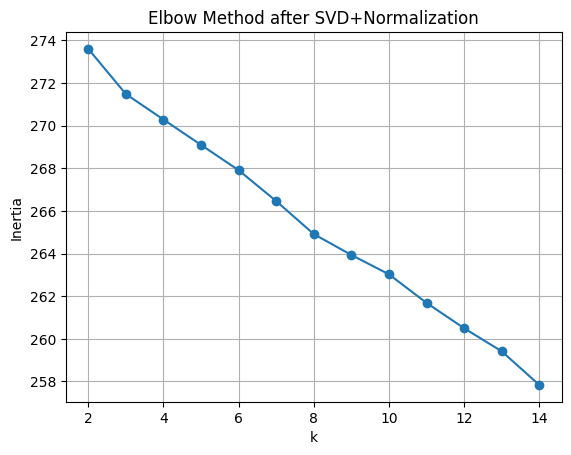

In [132]:
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
import numpy as np

k_values = range(2, 15)
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_final)

    inertias.append(km.inertia_)

    labels = km.labels_
    inertia = km.inertia_
    sil = silhouette_score(X_final, labels)
    nmi = normalized_mutual_info_score(df["bab"], labels)

    unique, counts = np.unique(labels, return_counts=True)
    sizes_str = ", ".join(
        f"C{int(c)}={int(cnt)}" for c, cnt in zip(unique, counts)
    )

    print(
        f"K={k:2d} → Inertia={inertia:.2f}, "
        f"Sil={sil:.4f}, NMI={nmi:.4f}, Sizes=[{sizes_str}]"
    )


plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method after SVD+Normalization")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


The ```elbow``` happens around k = 7 or k = 8.
k = 8 gives one of the best ```silhouette``` scores.
```NMI``` alone would suggest k = 11–12 but silhouette and cluster balance reject those values.
k = 8 produces the most stable and balanced ```cluster sizes```.

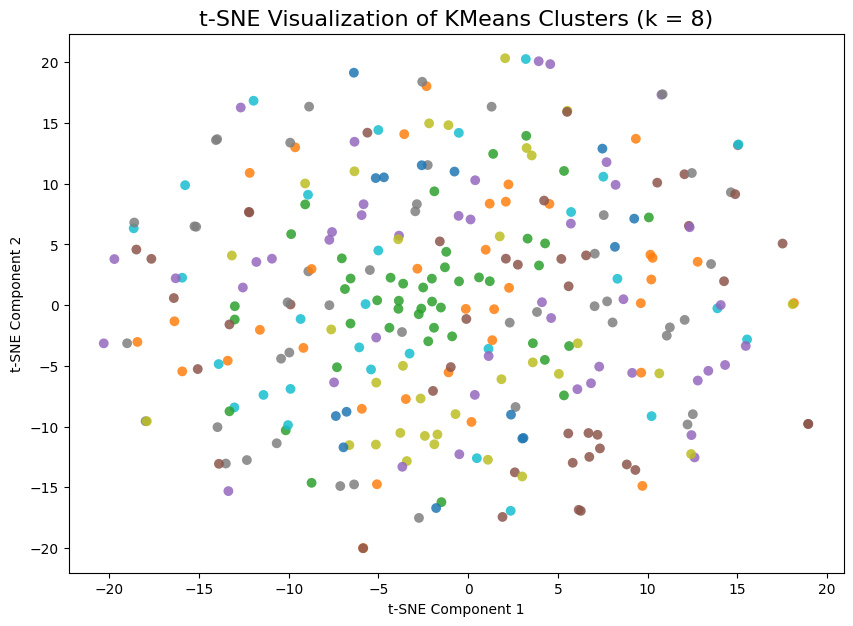

In [133]:
best_k = 8

kmeans_8 = KMeans(
    n_clusters=best_k,
    init="k-means++",
    n_init=30,
    max_iter=500,
    random_state=42,
    algorithm="elkan"
)

labels_8 = kmeans_8.fit_predict(X_final)


tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

X_2d = tsne.fit_transform(X_final)

plt.figure(figsize=(10, 7))

plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels_8,
    cmap='tab10',
    s=50,
    alpha=0.85,
    edgecolors='none'
)

plt.title("t-SNE Visualization of KMeans Clusters (k = 8)", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(False)
plt.show()


K-Means (k = 8) Visualization Using t-SNE

To visually inspect the clustering structure of the dataset, we fit a K-Means model with k = 8, selected based on the elbow curve, silhouette trends, and the relative balance of cluster sizes. The model was trained on the SVD-reduced and normalized TF-IDF vectors, which provide a compact and stable representation of the text data. We then applied t-SNE to project the high-dimensional embeddings into a two-dimensional plane for visualization. Although t-SNE does not preserve global geometry and typically produces overlapping clusters for text data, it offers an intuitive view of the local relationships between documents. The resulting scatter plot shows eight color-coded groups, illustrating how the hekayat distribute in reduced space. Due to the lexical uniformity and stylistic consistency of Golestan’s prose, the clusters naturally overlap in 2D, yet the visualization still reflects the underlying structure captured by K-Means in its original feature space.